In [1]:
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0)\
{ jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''',\
                raw=True)

Toggle code

In [2]:
import pyemma
import matplotlib.pylab as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import pyemma.coordinates as coor
import sys
%matplotlib inline
import pyemma.msm as msm
import pyemma.plots as mpl
import my_tools as my
import readwrite as rw
import cPickle as pickle
from scipy.spatial import distance
import gvec_func as gv
import pvec_func as pv
import dihedrals_func as dih

# 1 - Input data definition and discretization

In [3]:
# input files definitions
directo='/u/sbp/srnas1/giopina/Trajectories_Turner/AAAA-ol-tip3p/'
trajfiles=[]
for idir in ['aform','n.syn','s.anti','s.syn']:
    trajfiles.append(directo+idir+'/all-strip.netcdf')
topfile=directo+'/topol.pdb'

In [4]:
feat_dGP=coor.featurizer(topfile)
nres=4
feat_dGP.add_custom_func(gv.get_gvecs,4*nres*nres)

top=feat_dGP.topology
lista_dihedrals=dih.get_dihedrals_ndx(top)
for ll in lista_dihedrals:
    feat_dGP.add_dihedrals(ll,cossin=True)
lista_pucker=dih.get_pucker_ndx(top)
for ll in lista_pucker:
    feat_dGP.add_dihedrals(ll,cossin=True)
lista_chis=dih.get_chi_ndx(top)
feat_dGP.add_dihedrals(lista_chis,cossin=True)

inp_dGP = coor.source(trajfiles, feat_dGP)

Obtaining file info: 100% (4/4) [##################################] eta 00:00 |

In [5]:
# Files for output structures
featXout=coor.featurizer(topfile)
featXout.add_all()
inpXout = coor.source(trajfiles, featXout)

Obtaining file info: 100% (4/4) [##################################] eta 00:01 |

In [6]:
print 'N. trajectories =',inp_dGP.ntraj
print 'N. frames =',inp_dGP.n_frames_total()
print 'Total length =',inp_dGP.n_frames_total()/10000., 'microseconds'
print 
print 'Ideal number of microstates =',np.sqrt(inp_dGP.n_frames_total())

N. trajectories = 4
N. frames = 351314
Total length = 35.1314 microseconds

Ideal number of microstates = 592.717470638


## 1.1 - TICA analysis:

In [7]:
#%time traj=coor.load(trajfiles,feat_dGP,chunk_size=1000)

In [7]:
#tica_obj=coor.tica(traj,10)
#tica_traj=tica_obj.get_output()
#tica_dim,cumvar=my.get_tica_cumvar(tica_obj)
#print 'dimension=%d,%d' %(tica_dim,tica_obj.dimension())
#rw.write_tica_eval('dG_lt50',tica_obj)
#rw.write_tica_evec('dG_lt50',tica_obj)
#rw.write_tica_trajs('dG_lt50',tica_traj)
tica_dim=44
dire='/u/sbp/srnas2/giopina/markov/tetro/'
tica_traj=rw.read_tica_trajs(dire+'dG_lt50',4)
tiva_eval=rw.read_tica_eval(dire+'dG_lt50')
tiva_evec=rw.read_tica_evec(dire+'dG_lt50')
print 'TICA dimension (n. of eigenvectors considered) =',tica_dim

TICA dimension (n. of eigenvectors considered) = 44


##  1.2 - Clustering:

In [10]:
# Clustering with k-means
#%time cl = coor.cluster_kmeans(data=[X[:,0:tica_dim] for X in tica_traj], \
#                               k=400,stride=1,max_iter=50,fixed_seed=True)
#dtrajs = cl.assign(stride=1)
#rw.write_cl_dtrajs(dire+'dG_lt50_k400',dtrajs)
#rw.write_cl_centers(dire+'dG_lt50_k400',cl)
#rw.write_cl_indexes(dire+'dG_lt50_k400',cl)
#cl_centers=cl.clustercenters

In [8]:
dtrajs=rw.read_cl_dtrajs(dire+'dG_lt50_k400',4)
cl_centers=rw.read_cl_centers(dire+'dG_lt50_k400')
cl_indexes=rw.read_cl_indexes(dire+'dG_lt50_k400')

In [9]:
Ytot=tica_traj[0]
for i in range(1,len(tica_traj)):
    Ytot=np.concatenate((Ytot,tica_traj[i]))
ix=0
iy=1
z,x,y = np.histogram2d(Ytot[:,ix],Ytot[:,iy], bins=100)
F01 = -np.log(z)
extent01 = [x[0], x[-1], y[0], y[-1]]
ix=2
iy=1
z,x,y = np.histogram2d(Ytot[:,ix],Ytot[:,iy], bins=100)
F21 = -np.log(z)
del Ytot
extent21 = [x[0], x[-1], y[0], y[-1]]

/u/sbp/giopina/software/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log
/u/sbp/giopina/software/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log


/u/sbp/giopina/software/miniconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


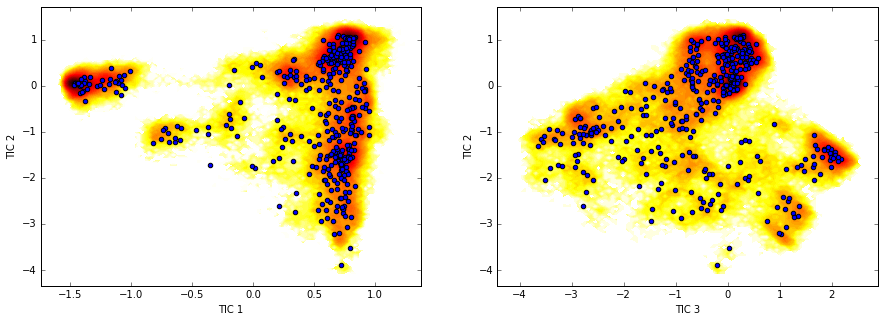

In [10]:
fig = plt.figure(figsize=(15,5))
plt.subplot2grid((1,2),(0,0))
ix=0
iy=1
plt.contourf(F01.T, 50, cmap=plt.cm.hot, extent=extent01)
plt.ylabel('TIC '+str(iy+1))
plt.xlabel('TIC '+str(ix+1))
plt.scatter(cl_centers[:,ix],cl_centers[:,iy])
plt.subplot2grid((1,2),(0,1))
ix=2
iy=1
plt.contourf(F21.T, 50, cmap=plt.cm.hot, extent=extent21)
plt.ylabel('TIC '+str(iy+1))
plt.xlabel('TIC '+str(ix+1))
plt.scatter(cl_centers[:,ix],cl_centers[:,iy])
plt.legend(loc=(1,0),numpoints=1,handlelength=0.7,ncol=2)

# 2 - Markov state model construction and analysis

## 2.1 - Implied timescales:

In [9]:
### Implied timescales
its=msm.its(dtrajs,lags=[1,5,10,20,30,40,50,60,80,100,120,150,200,250,300,400],nits=15)
rw.write_msm_its('dG_lt50_k400',its)
#its_lags,its_timescales=rw.read_msm_its(dire+'dG_lt50_k400')

estimating MaximumLikelihoodMSM: 100% (16/16) [####################] eta 00:01 /

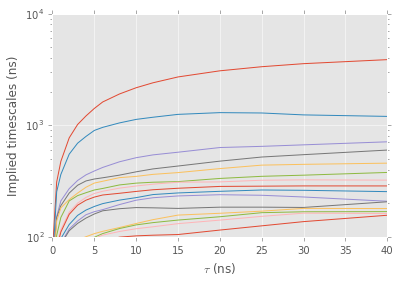

In [11]:

with plt.style.context(('ggplot')):    
    plt.plot(its.lags/10.,its.timescales[:,:25]/10.)
    plt.ylim(100,10000)
#plt.xlim(0,250)
    plt.yscale('log')
    #plt.grid()
    plt.ylabel('Implied timescales (ns)')
    plt.xlabel(r'$\tau$ (ns)')
    dire='/u/sbp/giopina/Dropbox/SISSA/markov/tetro/'
    name='tetro-its'
    for ext in ['.pdf','.png','.svg','.eps']:
        plt.savefig(dire+name+ext,dpi=200, bbox_inches='tight') 

## 2.2 - MSM construction and analysis: timescales and eigenvectors

In [11]:
#M=msm.estimate_markov_model(dtrajs,200)
#rw.write_msm('dG_lt50_k400_lm200',M)
M=rw.read_msm(dire+'dG_lt50_k400_lm200')

In [181]:
M.active_state_fraction

0.9975

In [29]:
BM=msm.bayesian_markov_model(dtrajs,200,nsamples=500)
bm_timescales_mean=BM.sample_mean('timescales')
bm_timescales_std=BM.sample_std('timescales')
bm_timescales_conf=BM.sample_conf('timescales')

Sampling MSMs: 100% (500/500) [####################################] eta 00:00 /

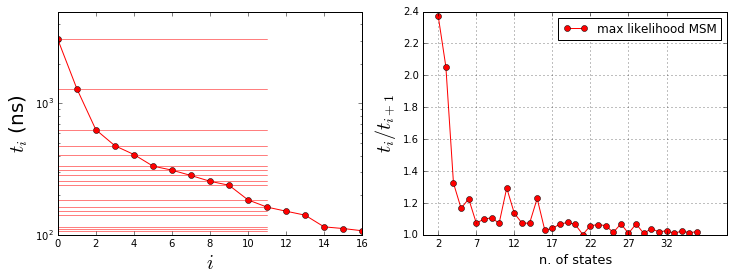

In [19]:
plt.figure(figsize=(12,4))
plt.subplot2grid((1,2),(0,0))
### Eigenvalues plot
plt.plot(M.timescales()[:17]/10,marker='o', color='red')
plt.plot([0,11],[80,80])
for ts in M.timescales()[:17]:
    plt.plot([0,11],[ts/10,ts/10],c='red',lw=0.5)
plt.yscale('log')
plt.ylim(100,5000)
plt.ylabel('$t_i$ (ns)',fontsize=20)
plt.xlabel('$i$',fontsize=20)
plt.subplot2grid((1,2),(0,1))

plt.plot(range(2,37),M.timescales()[0:35]/M.timescales()[1:36],\
         marker='o',color='red',label='max likelihood MSM')
plt.xlabel('n. of states',fontsize=13)
plt.ylabel('$t_i / t_{i+1}$',fontsize=20)
plt.grid()
plt.xticks(range(2,37,5))
plt.legend()

In [30]:
print 'MSM timescales:'
for i in range(7):
    print('%4.f +- %4.f ns' % (M.timescales()[i]/10, bm_timescales_std[i]/10)  )

MSM timescales:
3072 +- 1123 ns
1296 +-  567 ns
 631 +-  371 ns
 476 +-  361 ns
 409 +-  254 ns
 333 +-  141 ns
 311 +-   67 ns


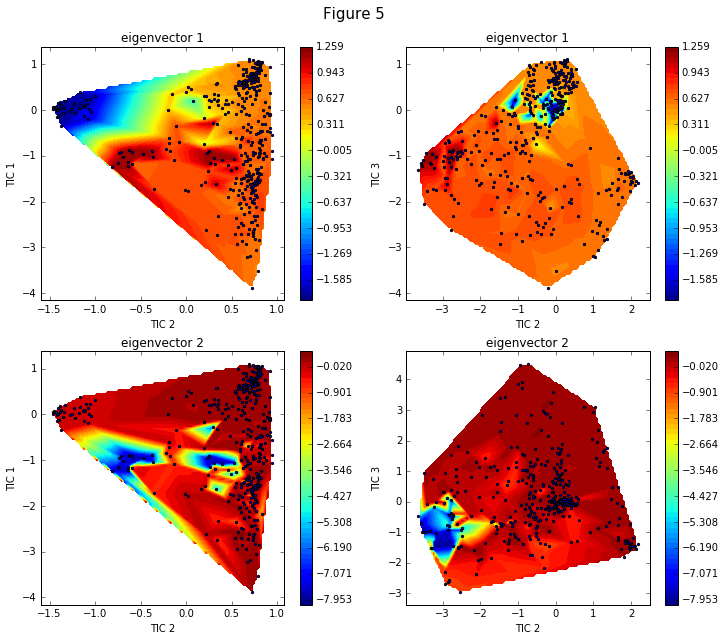

In [17]:
#cl_centers=cl.clustercenters
plt.figure(figsize=(12,10))
plt.subplot2grid((2,2),(0,0))
plt.text(1.5,2,'Figure 5',fontsize=15)
icomp=1
r2 = M.eigenvectors_right()[:,icomp]
mpl.scatter_contour(cl_centers[M.active_set,0], cl_centers[M.active_set,1], r2)
plt.title('eigenvector '+str(icomp))
plt.ylabel('TIC 1')
plt.xlabel('TIC 2')

plt.subplot2grid((2,2),(0,1))
icomp=1
r2 = M.eigenvectors_right()[:,icomp]
mpl.scatter_contour(cl_centers[M.active_set,2], cl_centers[M.active_set,1], r2)
plt.title('eigenvector '+str(icomp))
plt.ylabel('TIC 3')
plt.xlabel('TIC 2')

plt.subplot2grid((2,2),(1,0))
icomp=2
r2 = M.eigenvectors_right()[:,icomp]
mpl.scatter_contour(cl_centers[M.active_set,0], cl_centers[M.active_set,1], r2)
plt.title('eigenvector '+str(icomp))
plt.ylabel('TIC 1')
plt.xlabel('TIC 2')

plt.subplot2grid((2,2),(1,1))
icomp=2
r2 = M.eigenvectors_right()[:,icomp]
mpl.scatter_contour(cl_centers[M.active_set,2], cl_centers[M.active_set,3], r2)
plt.title('eigenvector '+str(icomp))
plt.ylabel('TIC 3')
plt.xlabel('TIC 2')

## 2.3 - Coarse graining the MSM with an hidden Markov model

In [19]:
HMM4=M.coarse_grain(4)
rw.write_hmm('dG_lt50_k400_lm200',HMM4)

16-09-16 10:49:37 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[2] WARNING  Requested coarse-grained model with 4 metastable states at lag=200.The ratio of relaxation timescales between 4 and 5 states is only 1.32414074908 while we recommend at least 1.5.  It is possible that the resulting HMM is inaccurate. Handle with caution.


In [32]:
BHMM4=msm.bayesian_hidden_markov_model(dtrajs,4,200,nsamples=500)
bhmm_timescales_mean=BHMM4.sample_mean('timescales')
bhmm_timescales_std=BHMM4.sample_std('timescales')
bhmm_timescales_conf=BHMM4.sample_conf('timescales')

/u/sbp/giopina/software/miniconda/lib/python2.7/site-packages/msmtools/analysis/dense/decomposition.py:530: ImaginaryEigenValueWarning: Using eigenvalues with non-zero imaginary part
  warnings.warn('Using eigenvalues with non-zero imaginary part', ImaginaryEigenValueWarning)
/u/sbp/giopina/software/miniconda/lib/python2.7/site-packages/msmtools/analysis/dense/pcca.py:287: ComplexWarning: Casting complex values to real discards the imaginary part
  evecs[:, i] /= math.sqrt(np.dot(evecs[:, i] * pi, evecs[:, i]))


Sampling HMSMs: 100% (500/500) [###################################] eta 00:00 -

In [33]:
print 'MSM timescales:'
for i in range(3):
        print('%4.f ns \t %4.f +- %4.f ns\t' % \
              (M.timescales()[i]/10,HMM4.timescales()[i]/10,bhmm_timescales_std[i]/10))

MSM timescales:
3072 ns 	 4685 +- 3646 ns	
1296 ns 	  781 +-  226 ns	
 631 ns 	  364 +-  110 ns	


In [20]:
HMM4.timescales()/10

array([ 4685.03647557,   781.24959615,   363.8018235 ])

In [173]:
bhmm_statdist_mean=BHMM4.sample_mean('stationary_distribution')
bhmm_statdist_std=BHMM4.sample_std('stationary_distribution')
for ii in range(nstates):
    print '%2.f (%2.f) +- %2.f'%\
    (HMM4.stationary_distribution[ii]*100,\
     bhmm_statdist_mean[ii]*100,\
     bhmm_statdist_std[ii]*100)

 9 ( 5) +-  4
18 (11) +-  6
53 (48) +- 16
19 (36) +- 21


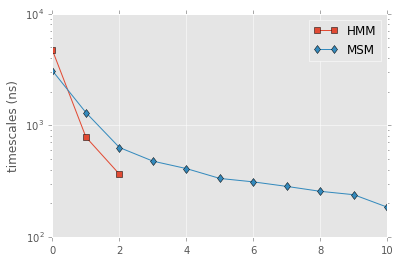

In [34]:
with plt.style.context(('ggplot')):
    plt.plot(HMM4.timescales()/10,marker='s',label='HMM')
    plt.plot(M.timescales()[:11]/10,marker='d',label='MSM')
    plt.yscale('log')
    plt.ylabel('timescales (ns)')
    plt.legend()

In [17]:
%time hmm4_its=msm.timescales_hmsm(dtrajs,4,lags=[1,10,50,100,150,200,300,400])

estimating MaximumLikelihoodHMSM: 100% (8/8) [#####################] eta 00:00 /CPU times: user 32min 44s, sys: 55.3 s, total: 33min 39s
Wall time: 15min 12s


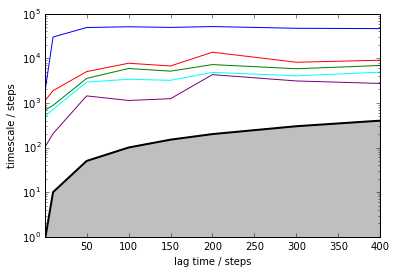

In [18]:
mpl.plot_implied_timescales(hmm4_its)

In [35]:
def plot_hmm(hmm_obj,ix=0,iy=1):
    colors=np.array(['blue','red','green','darkturquoise','orange','brown',\
                     'black','pink','darkolivegreen','darkviolet','royalblue'])
    Ytot=tica_traj[0]
    for i in range(1,len(tica_traj)):
        Ytot=np.concatenate((Ytot,tica_traj[i]))
    z,x,y = np.histogram2d(Ytot[:,ix],Ytot[:,iy], bins=100)
    F = -np.log(z)
    del Ytot
    extent = [x[0], x[-1], y[0], y[-1]]
    pcca_sets = hmm_obj.metastable_sets
    plt.contourf(F.T, 50, cmap=plt.cm.Greys_r, extent=extent)
    for ipcca in range(len(pcca_sets)):
        plt.scatter(cl_centers[pcca_sets[ipcca],ix], cl_centers[pcca_sets[ipcca],iy]\
                , color=colors[ipcca%len(colors)],label='set '+str(ipcca),alpha=0.7)
    plt.ylabel('TICA '+str(iy+1))
    plt.xlabel('TICA '+str(ix+1))

/u/sbp/giopina/software/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log


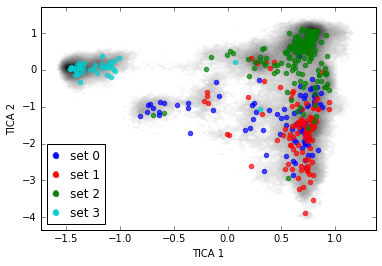

In [38]:
plot_hmm(HMM4)
plt.legend(numpoints=1,handlelength=0.7,loc=3)

In [21]:
hmm_obj=HMM4
nstates=hmm_obj.nstates
states_pos=np.array([\
            np.sum(cl_centers[hmm_obj.observable_set,:2]*\
                   hmm_obj.metastable_distributions[istate][:,np.newaxis],axis=0)\
            for istate in range(nstates)])

/u/sbp/giopina/software/miniconda/lib/python2.7/site-packages/pyEMMA-2.2.3-py2.7-linux-x86_64.egg/pyemma/util/_ext/shimmodule.py:132: PyEMMA_DeprecationWarning: Access to a moved module 'pyemma.msm.analysis' detected! Please use 'msmtools.analysis' in the future.
  category=PyEMMA_DeprecationWarning)


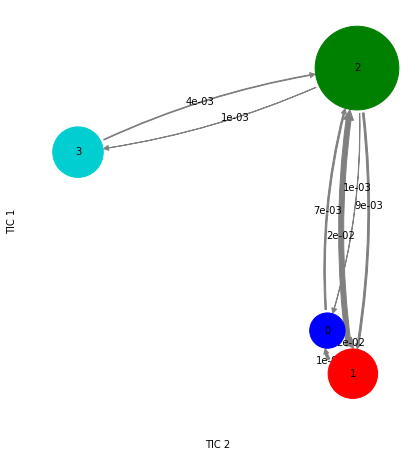

In [22]:
colors=np.array(['blue','red','green','darkturquoise','orange','brown',\
                 'darkviolet','black','pink','darkolivegreen','brown','royalblue'])
fff=mpl.plot_markov_model(hmm_obj.transition_matrix,\
                          pos=states_pos,state_colors=colors[:nstates],\
                         max_width=7)
plt.ylabel('TIC 1')
plt.xlabel('TIC 2')

In [23]:
from scipy.linalg import logm
hmm_rate_matrix=logm(HMM4.transition_matrix)
hmm_rate_matrix2=hmm_rate_matrix/HMM4.lagtime*10*1000 #rates in \mu s^-1
hmm_rate_matrix2[np.abs(hmm_rate_matrix2)<1e-02]=0.0

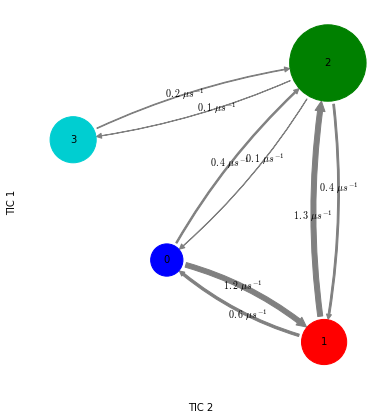

In [24]:
my_pos=np.array(states_pos)
my_pos[0]+=np.array([-1.1,0.35])
#my_pos[1]+=np.array([0,-2])
fff=mpl.plot_network(hmm_rate_matrix2,state_colors=colors,\
                     state_sizes=HMM4.stationary_distribution,\
                     pos=my_pos,\
                     arrow_label_format=r'$%2.1f$ $\mu s^{-1}$',\
                     max_width=7,max_height=7)
plt.ylabel('TIC 1')
plt.xlabel('TIC 2')

In [25]:
my_pos[:,0]*=1.2

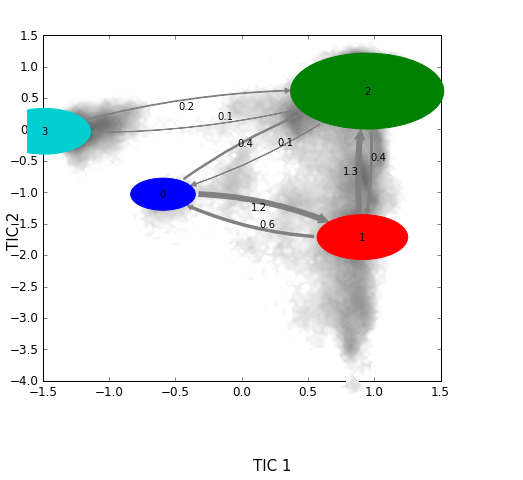

In [29]:
plt.contourf(F01.T, 50, cmap=plt.cm.Greys_r, extent=extent01,zorder=-1)
plt.ylabel('TIC 2',fontsize=15)
plt.xlabel('TIC 1',fontsize=15)

fff,ppp=mpl.plot_network(hmm_rate_matrix2,pos=my_pos,state_colors=colors,\
                     state_sizes=HMM4.stationary_distribution,arrow_label_format='%1.1f',\
                        max_width=10,max_height=8,state_scale=3)
plt.ylim(-5,2)
plt.xlim(-1.8,2)
bckax=fff.add_axes([0.15,0.25,0.63,0.6],zorder=-1)
#cacca=bckax.xaxis.set_ticks(np.arange(-1.7,2.3,0.5))
#cacca=bckax.yaxis.set_ticks(np.arange(-1.3,2.5,0.5))
plt.xticks(np.arange(-1.5,2.0,0.5),fontsize=12)
plt.yticks(np.arange(-4,2.,0.5),fontsize=12)

dire='/u/sbp/giopina/Dropbox/SISSA/markov/tetro/'
name='tetro-schema-new'
for ext in ['.pdf','.png','.svg','.eps']:
        plt.savefig(dire+name+ext,dpi=200) 

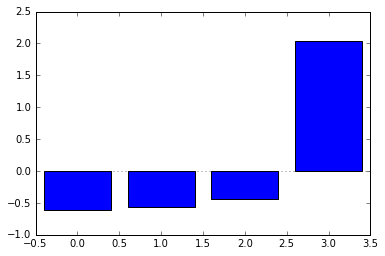

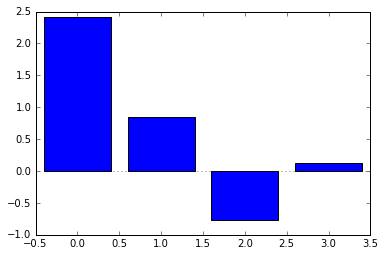

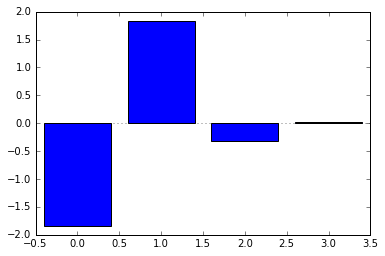

In [140]:
for icomp in range(1,nstates):
    plt.figure()
    plt.bar(np.array(range(nstates))-0.4,hmm_obj.eigenvectors_right()[:,icomp])
    plt.plot([0,4],[0,0],color='black',lw=1,ls=':',alpha=0.5)
    plt.xlim(-0.5,3.5)

# 3 -HMM's metastable states analysis

In [30]:
hmm_obj=HMM4
hmm_dist = hmm_obj.metastable_distributions
nstates=hmm_obj.nstates
hmm_samples = M.sample_by_distributions(hmm_dist, 1000)
outfiles = [dire+'dG_hmm'+str(i)+'_'+str(nstates)+'ms_1000states.xtc' for i in range(0,nstates)]
coor.save_trajs(inpXout, hmm_samples, outfiles=outfiles)

#stat_dist = M.stationary_distribution
#stat_samples = M.sample_by_distributions([stat_dist], 1000)
#coor.save_trajs(inpXout, stat_samples, outfiles=['dG_statdist.xtc'])

16-09-16 13:23:19 pyemma.coordinates.api INFO     Created file /u/sbp/giopina/Dropbox/SISSA/markov/tetro/dG_hmm0_4ms_1000states.xtc
16-09-16 13:23:20 pyemma.coordinates.api INFO     Created file /u/sbp/giopina/Dropbox/SISSA/markov/tetro/dG_hmm1_4ms_1000states.xtc
16-09-16 13:23:22 pyemma.coordinates.api INFO     Created file /u/sbp/giopina/Dropbox/SISSA/markov/tetro/dG_hmm2_4ms_1000states.xtc
16-09-16 13:23:24 pyemma.coordinates.api INFO     Created file /u/sbp/giopina/Dropbox/SISSA/markov/tetro/dG_hmm3_4ms_1000states.xtc


['/u/sbp/giopina/Dropbox/SISSA/markov/tetro/dG_hmm0_4ms_1000states.xtc',
 '/u/sbp/giopina/Dropbox/SISSA/markov/tetro/dG_hmm1_4ms_1000states.xtc',
 '/u/sbp/giopina/Dropbox/SISSA/markov/tetro/dG_hmm2_4ms_1000states.xtc',
 '/u/sbp/giopina/Dropbox/SISSA/markov/tetro/dG_hmm3_4ms_1000states.xtc']

## Stacked percentages

In [54]:
nstates=hmm_obj.nstates
import stackdef as stack
feat_stack=coor.featurizer(topfile)
for i in range(4):
    for j in range(i+1,4):
        print 'stacking between:',i,j
        feat_stack.add_custom_func(stack.get_stack_score,1,i,j)

print 'N. of features:',feat_stack.dimension()
### reading structures:
trajfiles_meta_states=[dire+'dG_hmm'+str(i)+'_'+str(nstates)+'ms_1000states.xtc' for i in range(nstates)]
### cmomputing observables
stack_meta_states=np.array(coor.load(trajfiles_meta_states,feat_stack,chunk_size=1000))

stacking between: 0 1
stacking between: 0 2
stacking between: 0 3
stacking between: 1 2
stacking between: 1 3
stacking between: 2 3
N. of features: 6
getting output of FeatureReader: 100% (4/4) [######################] eta 00:00 -

In [170]:
#print stack_meta_states
stack_percentages=[]
for istate in range(nstates):
    tmp_stack=[]
    for kres in range(6):
        print len(np.where(stack_meta_states[istate][:,kres]>1.)[0])/2.,
        tmp_stack.append(len(np.where(stack_meta_states[istate][:,kres]>1.)[0])/2.)
    stack_percentages.append(np.array(tmp_stack))
    print ''
stack_percentages=np.array(stack_percentages)

10.5 20.0 3.5 1.0 32.5 15.5 
7.5 5.0 8.5 16.0 11.0 32.5 
12.5 0.5 5.5 26.5 6.5 21.0 
0.0 97.5 57.0 56.5 0.0 0.0 


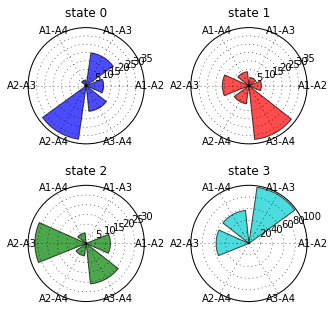

In [171]:
f,axs = plt.subplots(2,2,subplot_kw=dict(projection='polar'),figsize=(5,5))
f.subplots_adjust(hspace=0.3,wspace=0.4)
for istate in range(nstates):
    ax=axs[istate/2,istate%2]
#    ax=axs[istate]
    ax.bar([(x-0.4)*np.pi/3 for x in range(6)],stack_percentages[istate],\
           label='state '+str(istate),color=colors[istate],alpha=0.7)
    #plt.xticks([x*2*np.pi/6 for x in range(6)])
    cacca=ax.set_xticks([x*2*np.pi/6 for x in range(6)])
    labs=[]
    for ires in range(4):
        for jres in range(ires+1,4):
            labs.append('A%s-A%s' % (ires+1,jres+1))
    cacca=ax.set_xticklabels(labs)#,rotation=60)
    ax.set_title('state '+str(istate),fontsize=12)
#cacca=ax.set_yticklabels([])
#plt.legend(loc=(1.2,0.2))
dire='/u/sbp/giopina/Dropbox/SISSA/markov/tetro/'
name='tetro-stacking'
for ext in ['.pdf','.png','.svg','.eps']:
        plt.savefig(dire+name+ext,dpi=200, bbox_inches='tight') 

# Dihedrals (alpha, zeta)

In [72]:
feat_dih=coor.featurizer(topfile)
top=feat_dih.topology
lista_dihedrals=dih.get_dihedrals_ndx(top)
for ll in lista_dihedrals:
    feat_dih.add_dihedrals(ll,cossin=False)
lista_pucker=dih.get_pucker_ndx(top)
for ll in lista_pucker:
    feat_dih.add_dihedrals(ll,cossin=False)
lista_chis=dih.get_chi_ndx(top)
feat_dih.add_dihedrals(lista_chis,cossin=False)

In [73]:
dih_meta_states=np.array(coor.load(trajfiles_meta_states,feat_dih))

getting output of FeatureReader: 100% (4/4) [######################] eta 00:01 -

In [74]:
dih_names=[]
for lll,name in zip(lista_dihedrals,[r'$\alpha',r'$\beta',r'$\gamma',r'$\delta',r'$\epsilon',r'$\zeta']):
    for i in range(len(lll)):
        if name==r'$\alpha' or name==r'$\beta':
            dih_names.append(name+'_'+str(i+2)+'$')
        else:
            dih_names.append(name+'_'+str(i+1)+'$')
for lll,name in zip(lista_pucker,[r'$\nu^0',r'$\nu^1',r'$\nu^2',r'$\nu^3',r'$\nu^4']):
    for i in range(len(lll)):
        dih_names.append(name+'_'+str(i+1)+'$')
lll=lista_chis
name=r'$\chi'
for i in range(len(lll)):
    dih_names.append(name+'_'+str(i+1)+'$')
print len(dih_names), 'dihedrals'

44 dihedrals


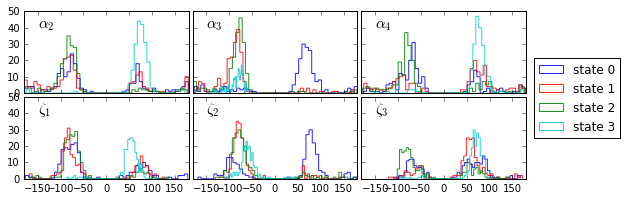

In [163]:
#8.27 in × 11.7
fig, axes = plt.subplots(2,3, \
        #gridspec_kw = {'width_ratios':[1.05]+[1 for x in range(nevec)]+[0.05]},\
        figsize=(9,3.),sharex=True,sharey=True)#,sharey=True,sharex=True)
plt.subplots_adjust(hspace=0.05,wspace=0.025)
iplot=0
for i_dih in[0,1,2]:
    ax=axes[0,iplot]
    ax.text(-150,40,dih_names[i_dih],fontsize=15)
    for istate in range(0,nstates):
        ax.hist(dih_meta_states[istate][:,i_dih]*180/np.pi,histtype='step',\
                lw=1.,bins=50,normed=False,\
                 label='state '+str(istate),color=colors[istate],alpha=0.85)
    iplot+=1
iplot=0
for i_dih in[17,18,19]:
    ax=axes[1,iplot]
    ax.text(-150,40,dih_names[i_dih],fontsize=15)
    for istate in range(0,nstates):
        ax.hist(dih_meta_states[istate][:,i_dih]*180/np.pi,histtype='step',\
                lw=1.,bins=50,normed=False,\
                 label='state '+str(istate),color=colors[istate],alpha=0.85)
    iplot+=1
    ax.set_xticks(range(-150,151,50))
plt.legend(loc=(1.05,0.5))
dire='/u/sbp/giopina/Dropbox/SISSA/markov/tetro/'
name='tetro-dih_alpha-zeta'
for ext in ['.pdf','.png','.svg','.eps']:
        plt.savefig(dire+name+ext,dpi=200, bbox_inches='tight') 

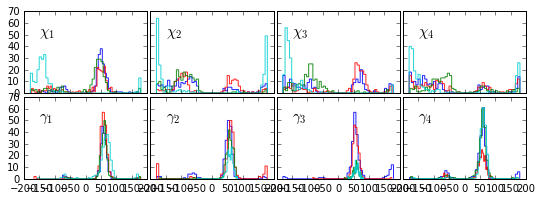

In [162]:
#8.27 in × 11.7
iplot=0
fig, axes = plt.subplots(2,4, \
        figsize=(9,3.),sharex=True,sharey=True)#,sharey=True,sharex=True)
plt.subplots_adjust(hspace=0.05,wspace=0.025)
for i_dih in range(40,44):
    ax=axes[0,iplot]
    ax.text(-150,50,dih_names[i_dih],fontsize=15)
    for istate in range(0,nstates):
        ax.hist(dih_meta_states[istate][:,i_dih]*180/np.pi,histtype='step',lw=1,bins=50,normed=False,\
                 label='state '+str(istate),color=colors[istate],alpha=0.85)
    iplot+=1
iplot=0
for i_dih in range(6,10):
    ax=axes[1,iplot]
    ax.text(-150,50,dih_names[i_dih],fontsize=15)
    for istate in range(0,nstates):
        ax.hist(dih_meta_states[istate][:,i_dih]*180/np.pi,histtype='step',lw=1,bins=50,normed=False,\
                 label='state '+str(istate),color=colors[istate],alpha=0.85)
    iplot+=1
dire='/u/sbp/giopina/Dropbox/SISSA/markov/tetro/'
name='tetro-dih_gamma-chi'
for ext in ['.pdf','.png','.svg','.eps']:
        plt.savefig(dire+name+ext,dpi=200, bbox_inches='tight') 

In [80]:
# G-vectors
feat_G=coor.featurizer(topfile)
nres=4
feat_G.add_custom_func(gv.get_gvecs,4*nres*nres)
inp_G = coor.source(trajfiles, feat_G)
### cmomputing observables
gvec_meta_states=np.array(coor.load(trajfiles_meta_states,feat_G))
var_names=[]
### G-VECTORS
nres=4
for ires in range(nres):
    for jres in range(nres):
        for mu in ['x','y','z','t']:
            var_names.append('$(G_{'+str(ires+1)+' '+str(jres+1)+'})_'+mu+'$')    

getting output of FeatureReader: 100% (4/4) [######################] eta 00:01 -

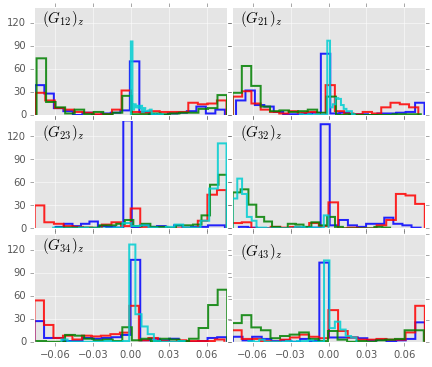

In [169]:
#for kgkg in [[6,18],[10,34],[14,50],[26,38],[30,54],[46,58]]:
            
with plt.style.context(('ggplot')):
    fig, axes = plt.subplots(3,2, \
        figsize=(7,6),sharex=True,sharey=True)#,sharey=True,sharex=True)
    plt.subplots_adjust(hspace=0.05,wspace=0.025)
    kplt=0
    for kgkg in [[6,18],[26,38],[46,58]]:
        for k_gvec,iplt in zip(kgkg,[0,1]):
            ax=axes[kplt,iplt]
            for istate in range(nstates):            
                ax.hist(gvec_meta_states[istate][:,k_gvec],
                        bins=20,color=colors[istate],histtype='step',lw=2,\
                    label=str(istate),alpha=0.85)
            ax.text(-0.07,120,var_names[k_gvec],fontsize=15)
#            if iplt==0:
#                plt.ylabel('freq. (p.t.)',fontsize=15)
        kplt+=1
        ax.set_yticks(range(0,160,30))
        ax.set_xticks(np.arange(-0.06,0.07,0.03))
dire='/u/sbp/giopina/Dropbox/SISSA/markov/tetro/'
name='tetro-gvec'
for ext in ['.pdf','.png','.svg','.eps']:
        plt.savefig(dire+name+ext,dpi=200, bbox_inches='tight') 

# Kinetics of stacking

In [76]:
inp_stack=coor.source(trajfiles,feat_stack,chunk_size=500)
%time avg_stack_cl=my.average_by_state(M,inp_stack)

getting output of FeatureReader: 100% (4/4) [######################] eta 00:00 -CPU times: user 7min 15s, sys: 2.26 s, total: 7min 17s
Wall time: 7min 18s


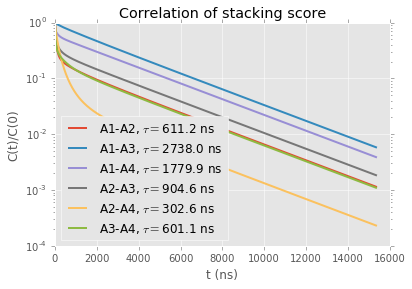

In [77]:
with plt.style.context(('ggplot')):
    kres=0
    for ires in range(4):
        for jres in range(ires+1,4):
#istack=0
            media_sq=np.dot(avg_stack_cl[:,kres],M.stationary_distribution)**2
            times,corr=M.correlation(avg_stack_cl[:,kres])
            acorr=(corr-media_sq)/(corr[0]-media_sq)
            t_corr=(0.5+np.sum(acorr[1:]))*M.lag/10
            plt.plot(times/10,acorr,label=r'A%d-A%d, $\tau=$%.1f ns'%(ires+1,jres+1,t_corr),\
                    lw=2)
            kres+=1
    plt.ylabel('C(t)/C(0)');plt.xlabel('t (ns)')
    plt.yscale('log')
    plt.legend(loc=3)
    plt.title('Correlation of stacking score')

In [180]:
#evec_idx=np.arange(1,M.nstates)
evec_idx=np.arange(3,100)
roba=np.tensordot(M.eigenvectors_left()[evec_idx,:],avg_stack_cl,axes=[1,0])
tau_a=np.sum( (roba**2)*M.timescales()[evec_idx-1,np.newaxis] ,axis=0)\
/np.sum(roba**2,axis=0)
print '\nStacking autocorrelation times:\n'
print 'A1-A2 = %2.1f ns' % (tau_a[0]/10.)
print 'A1-A3 = %2.1f ns' % (tau_a[1]/10.)
print 'A1-A4 = %2.1f ns' % (tau_a[2]/10.)
print 'A2-A3 = %2.1f ns' % (tau_a[3]/10.)
print 'A2-A4 = %2.1f ns' % (tau_a[4]/10.)
print 'A3-A4 = %2.1f ns' % (tau_a[5]/10.)


Stacking autocorrelation times:

A1-A2 = 102.1 ns
A1-A3 = 249.7 ns
A1-A4 = 121.4 ns
A2-A3 = 134.6 ns
A2-A4 = 200.7 ns
A3-A4 = 171.3 ns
